# Chapter 10. 회귀 분석으로 연속적 타깃 변수 예측

## 10.2 주택 데이터셋 탐색

In [1]:
import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/rasbt/'
                 'python-machine-learning-book-3rd-edition/'
                 'master/ch10/housing.data.txt',
                 header=None,
                 sep='\s+')
df.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS',
              'NOX', 'RM', 'AGE', 'DIS', 'RAD',
              'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


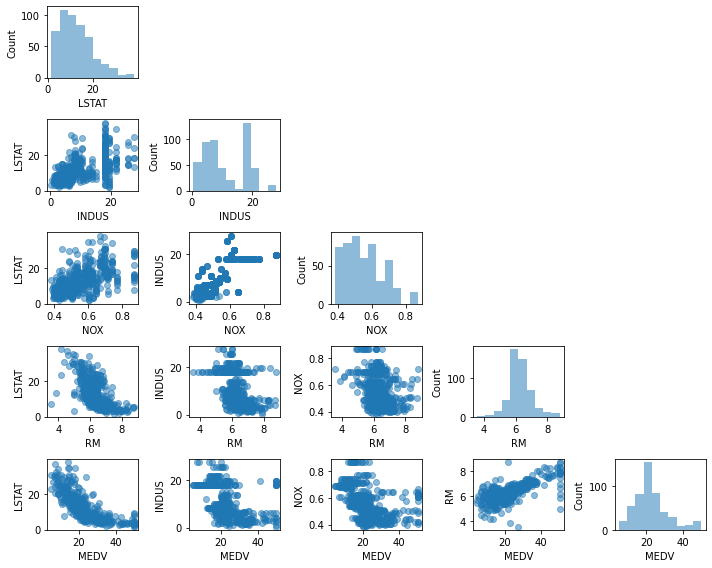

In [2]:
# install MLxtend library
# https://github.com/rasbt/mlxtend
# Mlxtend (machine learning extensions) is a Python library of useful tools for the day-to-day data science tasks.
# Sebastian Raschka 2014-2021
# http://rasbt.github.io/mlxtend/

import matplotlib.pyplot as plt
from mlxtend.plotting import scatterplotmatrix
cols = ['LSTAT', 'INDUS', 'NOX', 'RM', 'MEDV']
scatterplotmatrix(df[cols].values, figsize=(10, 8),
                  names=cols, alpha=0.5)
plt.tight_layout()
plt.show()

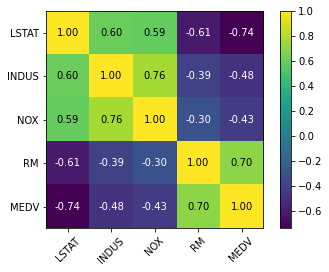

In [3]:
from mlxtend.plotting import heatmap
import numpy as np
cm = np.corrcoef(df[cols].values.T)
hm = heatmap(cm,
             row_names=cols,
             column_names=cols)
plt.show()

## 10.3 최소 제곱 선형 회귀 모델 구현

In [4]:
# adalineGD 이용하여 linear regression 구현
class LinearRegressionGD(object):
    
    def __init__(self, eta=0.001, n_iter=20):
        self.eta = eta
        self.n_iter = n_iter
        
    def fit(self, X, y):
        self.w_ = np.zeros(1 + X.shape[1])
        self.cost_ = []
        
        for i in range(self.n_iter):
            output = self.net_input(X)
            errors = y - output
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors**2).sum() / 2.0
            self.cost_.append(cost)
        return self
    
    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]
    
    def predict(self, X):
        return self.net_input(X)

In [5]:
X = df[['RM']].values
y = df['MEDV'].values
from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
sc_y = StandardScaler()
X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y[:, np.newaxis]).flatten()
lr = LinearRegressionGD()
lr.fit(X_std, y_std)

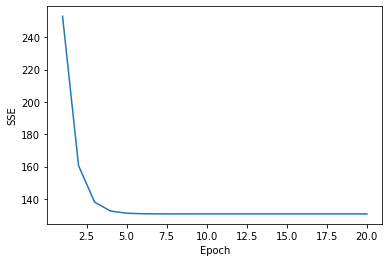

In [6]:
# 에포크의 함수로 비용을 그래프로 그려 보기
plt.plot(range(1, lr.n_iter + 1), lr.cost_)
plt.ylabel('SSE')
plt.xlabel('Epoch')
plt.show()

In [7]:
# 산점도와 회귀 직선 그려주는 함수 정의
def lin_regplot(X, y, model):
    plt.scatter(X, y, c='steelblue', edgecolor='white', s=70)
    plt.plot(X, model.predict(X), color='black', lw=2)
    return None

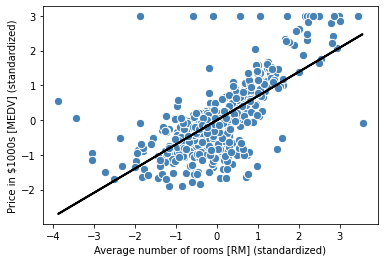

In [8]:
lin_regplot(X_std, y_std, lr)
plt.xlabel('Average number of rooms [RM] (standardized)')
plt.ylabel('Price in $1000s [MEDV] (standardized)')
plt.show()

In [9]:
# 표준화 되돌리기
num_rooms_std = sc_x.transform(np.array([[5.0]]))
price_std = lr.predict(num_rooms_std)
print("$1,000 단위 가격: %.3f" % \
    sc_y.inverse_transform(price_std))

$1,000 단위 가격: 10.840


In [10]:
print('기울기: %.3f' % lr.w_[1])

기울기: 0.695


In [11]:
print('절편: %.3f' % lr.w_[0])

절편: -0.000


In [12]:
from sklearn.linear_model import LinearRegression
slr = LinearRegression()
slr.fit(X, y)
print('기울기: %.3f' % slr.coef_[0])
print('절편: %.3f' % slr.intercept_)

기울기: 9.102
절편: -34.671


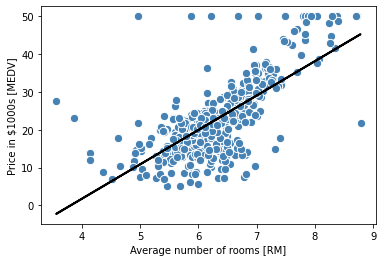

In [13]:
lin_regplot(X, y, slr)
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000s [MEDV]')
plt.show()

## 10.4 RANSAC (Random Sample Consensus)을 사용하여 안정된 회귀 모델 훈련

* outlier를 제거하는 것은 어렵고 식견이 필요하다

1. 랜덤하게 일부 샘플 (`min_samples`)을 정상치로 선택하여 모델을 훈련
2. 훈련된 모델에서 다른 모든 포인트를 테스트 -> `사용자가 입력한 허용 오차`안에 속한 포인트를 정상치에 추가
3. 모든 정상치를 사용하여 모델을 다시 훈련
4. 훈련된 모델과 정상치 간의 오차를 추정 (`loss`)
5. 성능이 사용자가 지정한 임계 값 (`residual_threshold`)에 도달하거나 지정된 반복 횟수 (`max_trials`)에 도달하면 알고리즘을 종료  
       cf) MAD (Median Absolute Deviation): 타깃 값 $y$의 중앙값 절대 편차를 의미 

In [14]:
from sklearn.linear_model import RANSACRegressor
ransac = RANSACRegressor(LinearRegression(),
                         max_trials=100,
                         min_samples=50,
                         loss='absolute_loss',
                         residual_threshold=5.0,
                         random_state=0)
ransac.fit(X, y)

RANSACRegressor(base_estimator=LinearRegression(), min_samples=50,
                random_state=0, residual_threshold=5.0)

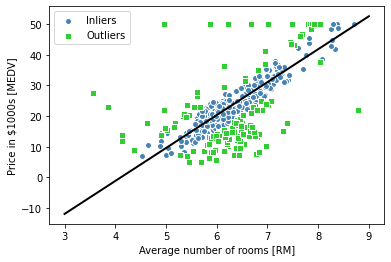

In [15]:
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)
line_X = np.arange(3, 10, 1)
line_y_ransac = ransac.predict(line_X[:, np.newaxis])
plt.scatter(X[inlier_mask], y[inlier_mask],
            c='steelblue', edgecolor='white',
            marker='o', label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask],
            c='limegreen', edgecolor='white',
            marker='s', label='Outliers')
plt.plot(line_X, line_y_ransac, color='black', lw=2)
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000s [MEDV]')
plt.legend(loc='upper left')
plt.show()

In [16]:
# 앞서 적합한 직선과 조금 다르다
print('기울기: %.3f' % ransac.estimator_.coef_[0])
print('절편: %.3f' % ransac.estimator_.intercept_)

기울기: 10.735
절편: -44.089


## 10.5 선형 회귀 모델의 성능 평가

In [17]:
from sklearn.model_selection import train_test_split
X = df.iloc[:, :-1].values
y = df['MEDV'].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)
slr = LinearRegression()
slr.fit(X_train, y_train)
y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)

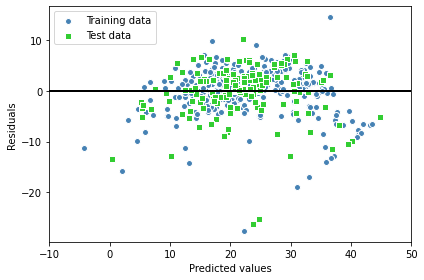

In [18]:
# 잔차도 그리기
plt.scatter(y_train_pred, y_train_pred - y_train,
            c='steelblue', marker='o', edgecolor='white',
            label='Training data')
plt.scatter(y_test_pred, y_test_pred - y_test,
            c='limegreen', marker='s', edgecolor='white',
            label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, colors='black', lw=2)
plt.xlim([-10, 50])
plt.tight_layout()
plt.show()

In [19]:
# 1) 훈련 데이터와 테스트 데이터 사이 MSE 계산
from sklearn.metrics import mean_squared_error
print('훈련 MSE: %.3f, 테스트 MSE: %.3f' % (
    mean_squared_error(y_train, y_train_pred),
    mean_squared_error(y_test, y_test_pred)
))

훈련 MSE: 19.958, 테스트 MSE: 27.196


In [20]:
# 2) R square 계산
from sklearn.metrics import r2_score
print('훈련 R^2: %.3f, 테스트 R^2: %.3f' %
      (r2_score(y_train, y_train_pred),
       (r2_score(y_test, y_test_pred))))

훈련 R^2: 0.765, 테스트 R^2: 0.673


## 10.6 회귀에 규제 적용

* Ridge
* Lasso
* Elastic net

## 10.7 선형 회귀 모델을 다항 회귀로 변환

In [23]:
# 이차 다항식 항을 추가
from sklearn.preprocessing import PolynomialFeatures
X = np.array([258.0, 270.0, 294.0, 320.0, 342.0,
              368.0, 396.0, 446.0, 480.0, 586.0])\
                  [:, np.newaxis]
y = np.array([236.4, 234.4, 252.8, 298.6, 314.2,
              342.2, 360.8, 368.0, 391.2, 390.8])
lr = LinearRegression()
pr = LinearRegression()
quadratic = PolynomialFeatures(degree=2)
X_quad = quadratic.fit_transform(X)

In [24]:
# 평범한 선형 회귀 모델을 훈련
lr.fit(X, y)
X_fit = np.arange(250, 600, 10)[:, np.newaxis]
y_lin_fit = lr.predict(X_fit)

In [25]:
# 변환된 특성에서 다변량 회귀 모델 훈련
pr.fit(X_quad, y)
y_quad_fit = pr.predict(quadratic.fit_transform(X_fit))

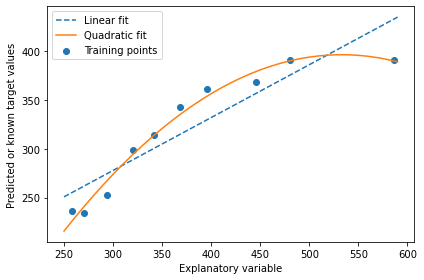

In [26]:
# 그래프 그리기
plt.scatter(X, y, label='Training points')
plt.plot(X_fit, y_lin_fit,
         label='Linear fit', linestyle='--')
plt.plot(X_fit, y_quad_fit,
         label='Quadratic fit')
plt.xlabel('Explanatory variable')
plt.ylabel('Predicted or known target values')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [27]:
# MSE, R^2 구하기
y_lin_pred = lr.predict(X)
y_quad_pred = pr.predict(X_quad)
print('훈련 MSE 비교 - 선형 모델: %.3f, 다항 모델: %.3f' % (
    mean_squared_error(y, y_lin_pred),
    mean_squared_error(y, y_quad_pred)
))
print('훈련 R^2 비교 - 선형 모델: %.3f, 다항 모델: %.3f' % (
    r2_score(y, y_lin_pred),
    r2_score(y, y_quad_pred)
))

훈련 MSE 비교 - 선형 모델: 569.780, 다항 모델: 61.330
훈련 R^2 비교 - 선형 모델: 0.832, 다항 모델: 0.982


### 10.7.2 주택 데이터셋을 사용한 비선형 관계 모델링

In [28]:
X = df[['LSTAT']].values
y = df['MEDV'].values

regr = LinearRegression()

In [29]:
# 이차, 삼차 다항식 특성 만들기
quadratic = PolynomialFeatures(degree=2)
cubic = PolynomialFeatures(degree=3)
X_quad = quadratic.fit_transform(X)
X_cubic = cubic.fit_transform(X)

In [ ]:
# 학습된 모델을 그리기 위해 특성 범위를 만듦
X_fit = np.arange(X.min(), X.max(), 1)[:, np.newaxis]

regr = regr.fit(X, y)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y, regr.predict(X))
